In [1]:
# from moviepy.editor import VideoFileClip

# def extract_audio_from_mp4(mp4_file_path, output_wav_path):
#     # 读取 MP4 文件
#     video_clip = VideoFileClip(mp4_file_path)
    
#     # 提取音频
#     audio_clip = video_clip.audio
    
#     # 保存为 WAV 文件
#     audio_clip.write_audiofile(output_wav_path, codec='pcm_s16le')

#     # 释放资源
#     audio_clip.close()
#     video_clip.close()

# # 示例调用
# mp4_file_path = "VID_20240815_110341_204.mp4"
# output_wav_path = "VID_20240815_110341_204.wav"
# extract_audio_from_mp4(mp4_file_path, output_wav_path)


In [2]:
from models.moe_research.w2v2_moe_fz24_aasist import Model
import torch 
DEVICE = "cpu"
# DEVICE = "cuda:2"
md = Model()
ckp = torch.load("a_log/noft_24/2_4_128/version_1/checkpoints/best_model-epoch=11-dev_eer=0.3560-loss=0.0015.ckpt", map_location=DEVICE)
# print(ckp)
# pretrain_model.masked_spec_embed

/data8/wangzhiyong/miniconda3/envs/icassp01/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at datasets/pretrained_model/facebook/wav2vec2-xls-r-300m and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# print(ckp['state_dict'])
from collections import OrderedDict
new_ckp = OrderedDict(((key[6:], value) if key.startswith('model.') else (key, value)) for key, value in ckp['state_dict'].items())


In [4]:
md.load_state_dict(new_ckp,strict=False)
md.to(DEVICE)

Model(
  (pretrain_model): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projectio

In [5]:
# import torchaudio,torch
# import torchaudio.transforms as T
# datalist = []
# with open("/data8/wangzhiyong/project/fakeAudioDetection/icassp01/moe_w2v2_lightning/datasets/other/testone_0821/allpath.txt", 'r', encoding='utf-8') as file:
#     for line in file:
#         # 去掉每行末尾的换行符
#         line = line.strip()
#         datalist.append(line)

# for tobetest in datalist:
#         name = tobetest.split("/")[-1]
#         try:
#                 testone,sr = torchaudio.load(tobetest)
#                 # testone,sr = torchaudio.load("test/VID_20240815_110341_204.wav")
#                 resampler = T.Resample(orig_freq=sr, new_freq=16000)
#                 waveform = resampler(testone)
#                 if waveform.size(0) > 1:
#                         waveform = torch.mean(waveform, dim=0, keepdim=True)  # 转换为单通道
#                 output = md(waveform.to(DEVICE))
#                 print(f"{name} {output[0].softmax(1).detach().cpu().numpy()[0][1]}")
#         except Exception as e:
#                 print(name)

In [10]:
import torchaudio,torch
import torchaudio.transforms as T

tobetest = "/data8/wangzhiyong/project/fakeAudioDetection/icassp01/moe_w2v2_lightning/datasets/other/testone_0821/real/librispeech/dev-other/7601/291468/1907.wav"

testone,sr = torchaudio.load(tobetest)
# testone,sr = torchaudio.load("test/VID_20240815_110341_204.wav")
resampler = T.Resample(orig_freq=sr, new_freq=16000)
waveform = resampler(testone)

if waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)  # 转换为单通道
output = md(waveform.to("cpu"))

print(output[0].softmax(1).detach().cpu().numpy()[0][1]
)

1.7241106e-05


In [7]:
# # output[1][0][1].shape
# import matplotlib.pyplot as plt
# import numpy as np
# features = [q.cpu() for q in output[1][0]]

# def draw(features,row = 4,column = 7, height = 20,width = 10):
#     # 假设我们有 25 个特征矩阵，每个大小为 [1, 537, 1024]
#     # 创建一个 4x7 的画布
#     fig, axs = plt.subplots(row, column, figsize=(height, width))

#     # 遍历所有特征并绘制它们
#     for i in range(row):
#         for j in range(column):
#             idx = i * column + j  # 当前特征的索引
#             if idx < len(features):
#                 feature = features[idx].squeeze()  # 移除第一个维度，得到 [537, 1024] 的数组
#                 axs[i, j].imshow(feature, cmap='viridis', aspect='auto')  # 绘制特征图
#                 axs[i, j].set_title(f"Feature {idx+1}")
#                 axs[i, j].axis('off')  # 关闭坐标轴

#     # 调整子图之间的间距
#     plt.tight_layout()
#     plt.show()



In [8]:
draw([q.cpu() for q in output[1][0]] )

NameError: name 'draw' is not defined

In [ ]:
# # 假设你有 24 个形状为 [1, 537, 537] 的特征
# features = [torch.mean(q, dim=1).cpu() for q in output[1][1]]
# def draw_att(features):
#     # 创建一个 4x6 的画布
#     fig, axs = plt.subplots(4, 6, figsize=(15, 10))

#     # 将每个特征绘制在画布上
#     for i in range(4):
#         for j in range(6):
#             # 提取对应的特征
#             feature = features[i * 6 + j].squeeze()  # 移除第一个维度 [1, 537, 537] -> [537, 537]
            
#             # 显示图像
#             axs[i, j].imshow(feature, cmap='viridis')
#             axs[i, j].axis('off')  # 关闭坐标轴

#     # 调整画布布局并显示
#     plt.tight_layout()
#     plt.show()


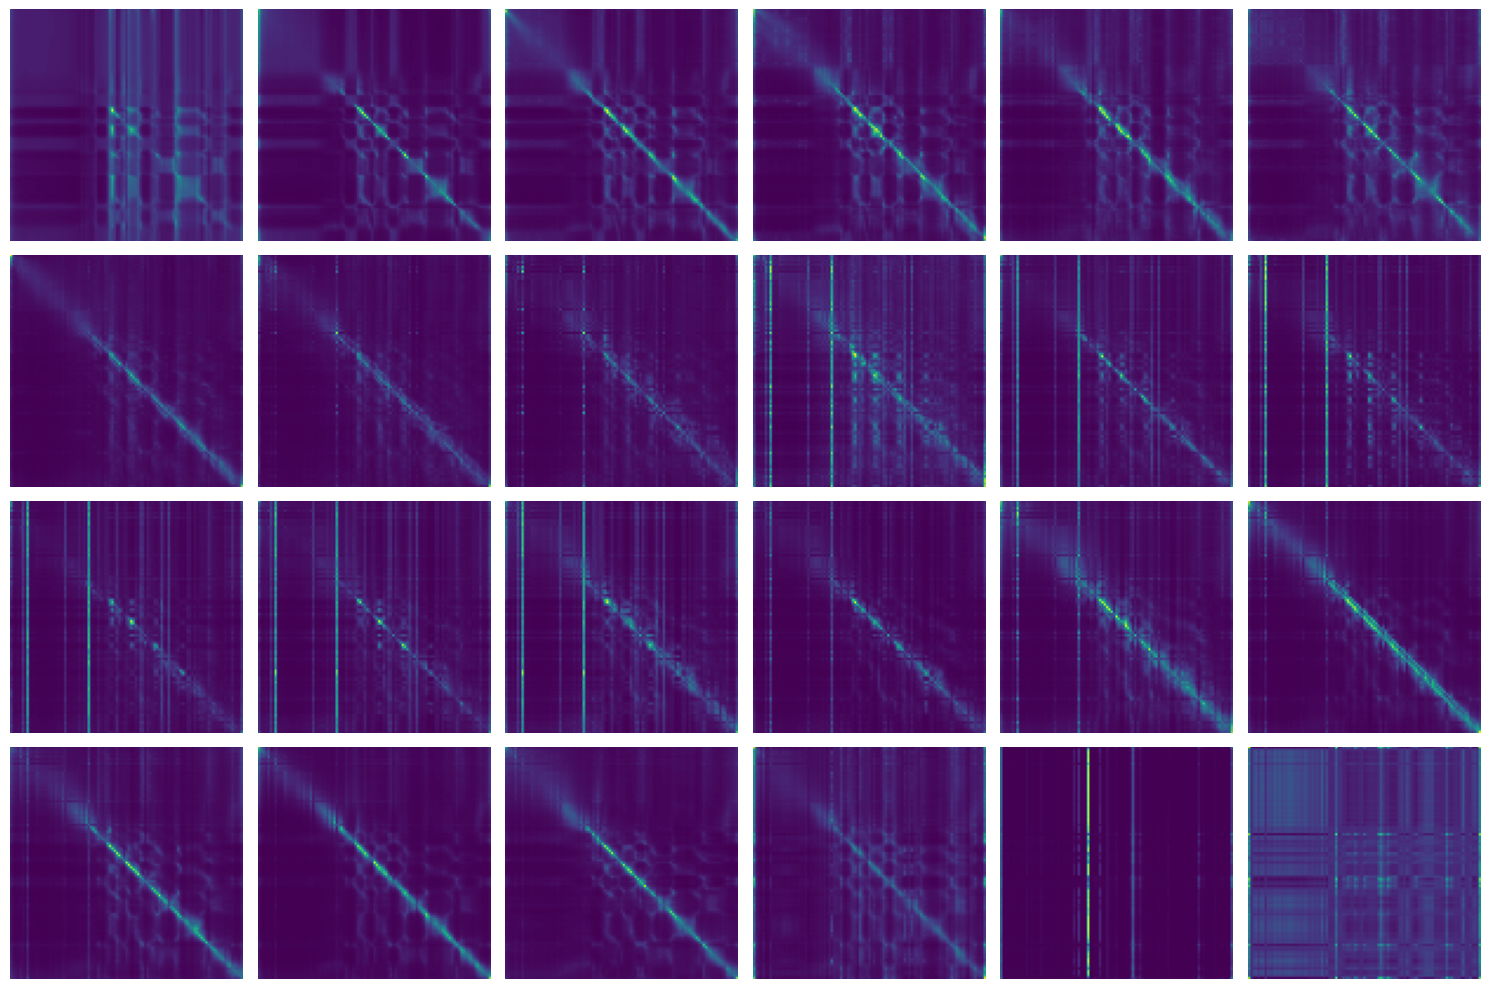

In [ ]:
# draw_att(features)

In [ ]:
# 打开文件
with open('导出的条目.csv', 'r') as file:
    # 遍历文件的每一行
    for line in file:
        # 使用逗号分隔行内容
        elements = line.strip().split(',')
        
        # 检查是否有足够的元素
        if len(elements) >= 5:
            # 输出第五个元素（索引为 4）
            print(elements[4])
        else:
            print("此行元素不足5个:", line)
